# Applying CLIP model

In [10]:
import os
import matplotlib.pyplot as plt
import clip as clp
import torch
from torchvision.datasets import CIFAR100
#from torchvision.datasets import CocoDetection
import numpy as np
import PIL
from keras.preprocessing import image

%matplotlib inline

#Had OpenMPI issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First test with draw image

In [2]:
from generate import get_test_images
from config import *

(48, 12, 80, 80)


In [22]:
images = get_test_images(80,80)

C:\Users\ingma\Documents\Kool\Semester-2\Tehisnärvivõrgud\constellation-recognition\draw\utility.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return autograd.Variable(data,*args, **kwargs)


In [29]:
images = np.array(images[:10])

In [30]:
print(images[0])

[[4.67930988e-07 1.10663689e-06 2.58852697e-06 ... 2.39782821e-05
  1.25163688e-05 6.33973013e-06]
 [1.97470990e-06 4.89390413e-06 2.85654914e-05 ... 7.78669491e-05
  4.34593494e-05 2.37072964e-05]
 [7.72436670e-06 1.83579614e-05 3.83229562e-05 ... 2.31766840e-04
  1.38821066e-04 8.17325999e-05]
 ...
 [1.75437697e-06 5.94269204e-06 1.92617990e-05 ... 1.94903657e-01
  1.88069925e-01 1.67362303e-01]
 [7.42707527e-07 2.72920443e-06 9.63080402e-06 ... 1.72503427e-01
  1.59466565e-01 1.32764056e-01]
 [3.07365838e-07 1.23213363e-06 4.75338857e-06 ... 1.43334851e-01
  1.24396496e-01 9.39141363e-02]]


In [35]:
images[images > 0.2] = 1

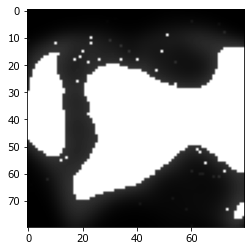

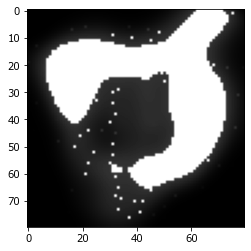

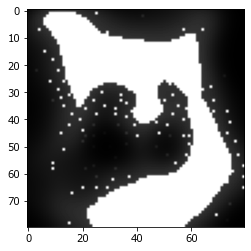

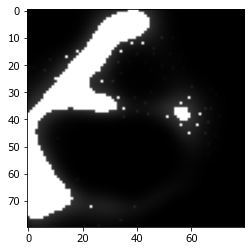

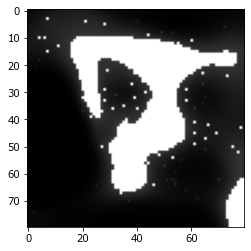

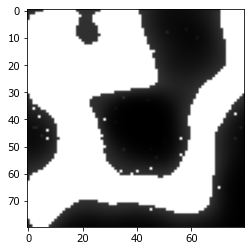

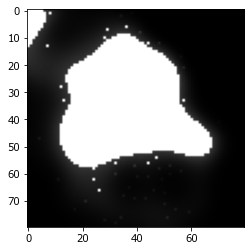

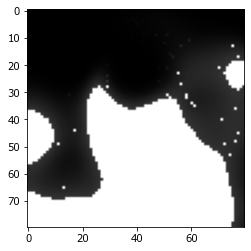

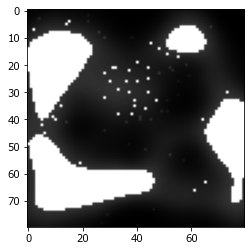

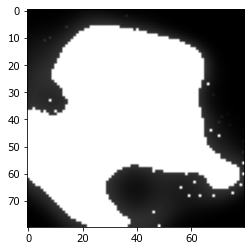

In [36]:
for img in images:
    plt.imshow(img, cmap="gray")
    plt.show()

In [11]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
#Different architectures, choose one
model, preprocess = clp.load('ViT-B/32', device) #Faster
#model, preprocess = clip.load('RN50x4', device) #Better but takes more time


In [5]:
# Download the dataset (not necessary, as only interested in classes)
#cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
#Coco = CocoDetection(root=os.path.expanduser("~/.cache"), download=True, train=False)

In [16]:
#Available classifications from different datasets
#combinedClasses.txt - CoCo + CIFAR100 (around 160 classes, removed duplicates)
#combinedClassesAdditional.txt -CoCo + CIFAR100 + classes about pictures which constellations are in set but 
#not in either CoCo or CIFAR100 classes (around 180 classes, removed duplicates)
#cocoClasses.txt - CoCo (80 classes)
#cifarClasses.txt - Cifar100 (100 classes)
#imagenet_classes.txt - Imagenet classes (around 1000 classes)
#things_classes.txt - Imagenet classes (around 1000 classes)

chosenDataset = "things_classes.txt"
# Read the categories
with open(os.path.join("..", "classes", chosenDataset), "r") as f:
    categories = [s.strip() for s in f.readlines()]

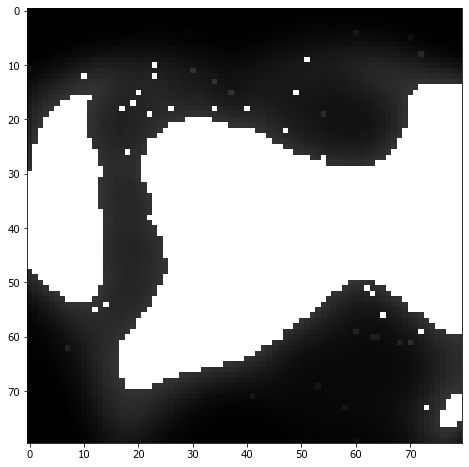


Top predictions for:

     springboard: 0.88%
             rim: 0.77%
          filter: 0.58%
     speedometer: 0.47%
        eyepiece: 0.44%


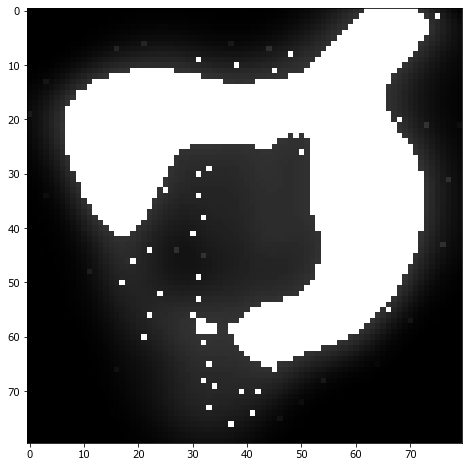


Top predictions for:

     springboard: 0.84%
             rim: 0.74%
          filter: 0.67%
        eyepiece: 0.45%
          gasket: 0.43%


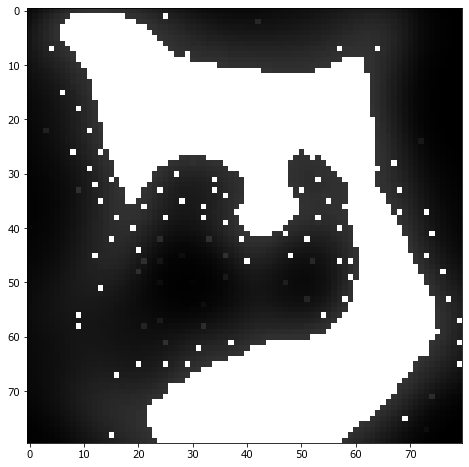


Top predictions for:

             rim: 0.70%
     springboard: 0.67%
          filter: 0.60%
        eyepiece: 0.45%
          gasket: 0.38%


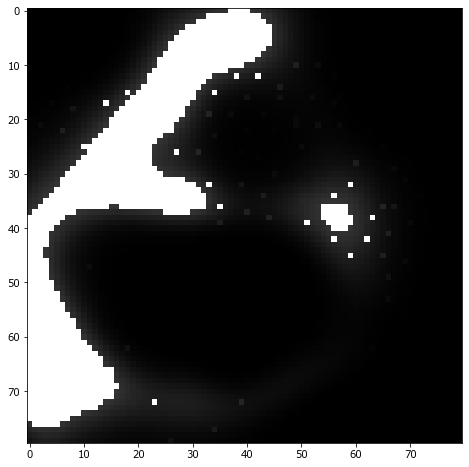


Top predictions for:

           light: 0.62%
          filter: 0.58%
      flashlight: 0.48%
        charcoal: 0.48%
             rim: 0.48%


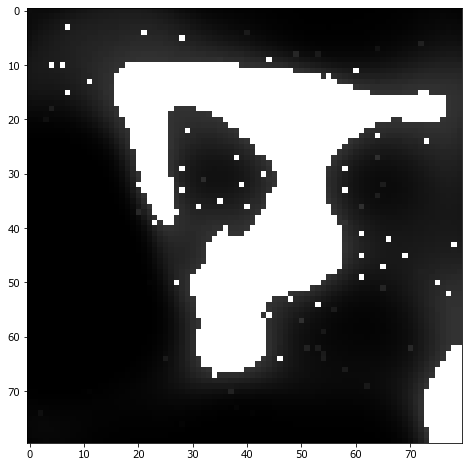


Top predictions for:

             rim: 0.61%
     springboard: 0.50%
          filter: 0.49%
        charcoal: 0.38%
           light: 0.37%


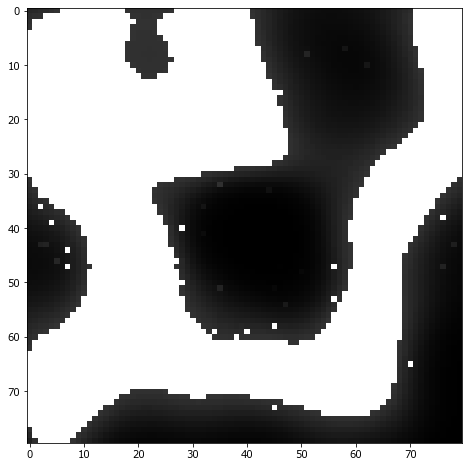


Top predictions for:

     springboard: 0.82%
             rim: 0.75%
          filter: 0.63%
        eyepiece: 0.43%
           timer: 0.40%


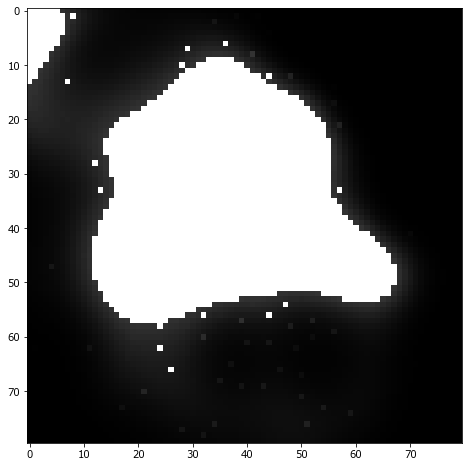


Top predictions for:

          filter: 0.71%
     springboard: 0.69%
             rim: 0.62%
           light: 0.51%
        eyepiece: 0.49%


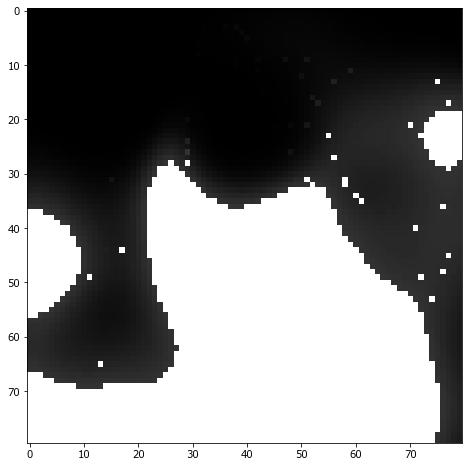


Top predictions for:

             rim: 0.64%
     springboard: 0.62%
          filter: 0.47%
        eyepiece: 0.41%
          gasket: 0.39%


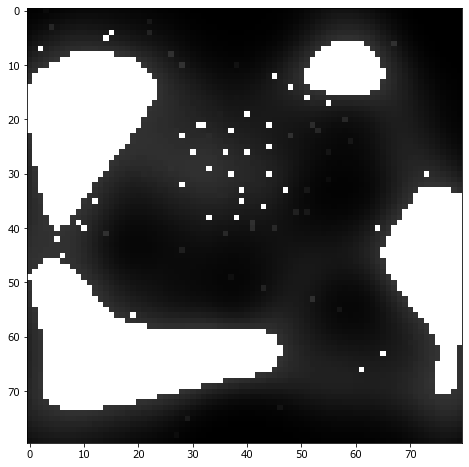


Top predictions for:

             rim: 0.60%
     springboard: 0.60%
          filter: 0.51%
           light: 0.43%
        eyepiece: 0.42%


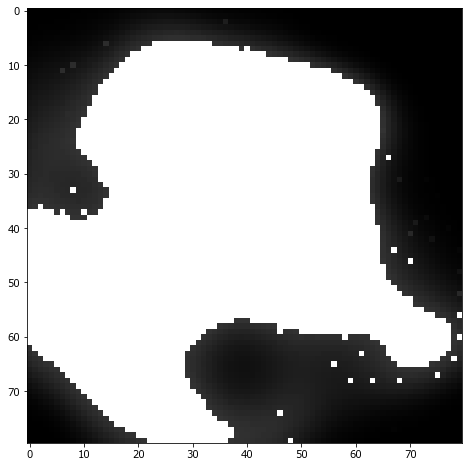


Top predictions for:

     springboard: 0.87%
             rim: 0.72%
          filter: 0.65%
     speedometer: 0.43%
        eyepiece: 0.42%


In [38]:
# Prepare the inputs
#image, class_id = cifar100[3637]

for img in images:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    axes.imshow(img, cmap="gray")
    plt.show()
    
    image = PIL.Image.fromarray(img)
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clp.tokenize(f"a photo of a {c}") for c in categories]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

    # Print the result
    print("\nTop predictions for:\n")
    for value, index in zip(values, indices):
        print(f"{categories[index]:>16s}: {100 * value.item():.2f}%")